In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from VLC_init import *


"""
*: coordinate center of cari

|--------|                     
| car1   |                      
|-------*|
         |
       y |                   |---------|
         |                   |  car2   |
         |-------------------|*--------|
                    d

"""

vlc_obj = VLC_init()
vlc_obj.update_lookuptable()
print(vlc_obj.H)
dt = 5e-9
t = np.arange(0, 1e-2, dt)
noise = np.random.normal(0, 1e-1, np.size(t))
delay1 = vlc_obj.delays[0][1]*2
delay2 = vlc_obj.delays[1][1]*2
f = 5e6
r = 399
N = 1
fclk = 1/(2*dt)
l = 1
dm = []

[[1.30566923e-10 9.19293971e-11]
 [2.41169141e-10 1.30566923e-10]]


(0, 1e-06)

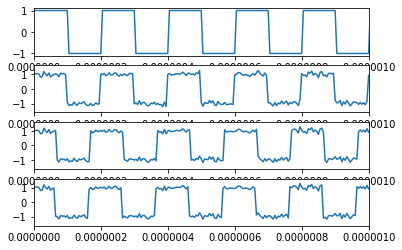

In [2]:
s_e = signal.square(2 * np.pi * f * t) + noise
s_r = {1: signal.square(2 * np.pi * f * (t + delay1)) + noise, 
       2: signal.square(2 * np.pi * f * (t + delay2)) + noise}
s_h = signal.square(2 * np.pi * f * (r/(r+1)) * t)

s_gate = (signal.square(2 * np.pi * (f / (N * (r+1))) *t) > 0)
s_clk  = np.zeros(np.size(t))
s_clk[np.arange(1, np.size(s_clk), 2)] = 1

s_eh = np.zeros(np.size(t))
s_rh = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}
s_phi = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}
s_phi_h = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}
s_phi_hh = {1: np.zeros(np.size(t)), 2: np.zeros(np.size(t))}

s_eh_state = 0
s_rh_state = {1: 0, 2: 0}

counts = {1: [], 2: []}
M = {1: 0, 2: 0}

plt.figure()
plt.subplot(4, 1, 1)
plt.xlim(0,1e-6)
plt.plot(t, s_h)
plt.subplot(4, 1, 2)
plt.xlim(0,1e-6)
plt.plot(t, s_e)
plt.subplot(4, 1, 3)
plt.plot(t, s_r[1])
plt.xlim(0,1e-6)
plt.subplot(4, 1, 4)
plt.plot(t, s_r[2])
plt.xlim(0,1e-6)

In [ ]:
for i in range(1, np.size(t)):
    
    if(s_h[i] - s_h[i-1] == 2):
        
        if(s_e[i] > 0):
            s_eh_state = 1
        else:
            s_eh_state = 0

        if(s_r[1][i]>0):
            s_rh_state[1] = 1
        else:
            s_rh_state[1] = 0
        
        if(s_r[2][i]>0):
            s_rh_state[2] = 1
        else:
            s_rh_state[2] = 0
            
    s_eh[i] = s_eh_state
    s_rh[1][i] = s_rh_state[1]
    s_rh[2][i] = s_rh_state[2]
    
    s_phi[1][i] = np.logical_xor(s_eh_state, s_rh_state[1])
    s_phi[2][i] = np.logical_xor(s_eh_state, s_rh_state[2])
    
    s_phi_h[1][i] = s_phi[1][i] * s_gate[i]
    s_phi_h[2][i] = s_phi[2][i] * s_gate[i]
    
    s_phi_hh[1][i] = s_phi_h[1][i] * s_clk[i]
    s_phi_hh[2][i] = s_phi_h[2][i] * s_clk[i]
    
    if(s_gate[i] == 1):
        if(s_phi_hh[1][i] == 1):
            M[1] += 1
        if(s_phi_hh[2][i] == 1): 
            M[2] += 1
        update_flag = 1
    else:
        if(update_flag == 1):
            counts[1].append(M[1])
            counts[2].append(M[2])
            M[1] = 0
            M[2] = 0
            update_flag = 0

In [ ]:
plt.figure()
plt.subplot(6, 1, 1)
plt.plot(t, s_h)
plt.subplot(6, 1, 2)
plt.plot(t, s_e)
plt.subplot(6, 1, 3)
plt.plot(t, s_eh)
plt.subplot(6, 1, 4)
plt.plot(t, s_phi[1])
plt.subplot(6, 1, 5)
plt.plot(t, s_phi_h[1])
plt.subplot(6, 1, 6)
plt.plot(t, s_phi_hh[1])

In [ ]:
dm = {'dr': ((vlc_obj.c/2) * (np.max(counts[1]) / ((r+1) * N * fclk))),
      'dl': ((vlc_obj.c/2) * (np.min(counts[2]) / ((r+1) * N * fclk)))}
print(dm)

In [ ]:
dr = dm['dr'] # vlc_obj.distances[0][1]
print("Calculated distance error: ", (vlc_obj.distances[0][1] - dr) / vlc_obj.distances[0][1])
dl = dm['dl'] # vlc_obj.distances[1][1]
print("Calculated distance error: ", (vlc_obj.distances[1][1] - dl) / vlc_obj.distances[1][1])

In [ ]:
y = (dl**2 - dr**2 + l**2) / (2*l)
print(y)
x = -np.sqrt(dl**2 - y**2)
print(x)

In [ ]:
print("Coords: ")
print("(", x,  ", ", y, ")")
print("(", x,  ", ", y+1, ")")